### Importing the libraries that will be used in the model

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Synthetic over sampling of minority
from imblearn.over_sampling import SMOTE

# Complexity
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

# Algorithms
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier

# Training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

# Evaluating
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score

### Loading the dataset into a pandas dataframe

In [2]:
df = pd.read_csv("/Users/yadushyadav/downloads/healthcare-stroke/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


### Viewing the dataset and fixing irregularities

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
df['smoking_status'].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [5]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [6]:
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [7]:
print(df[["gender", "stroke"]].groupby(['gender'], as_index=False).mean())

   gender    stroke
0  Female  0.016793
1    Male  0.019860
2   Other  0.000000


In [8]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Other': 2} ).astype(int)

In [9]:
df['Residence_type'].value_counts()

Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

In [10]:
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1} ).astype(int)

In [11]:
df['ever_married'].value_counts()

Yes    27938
No     15462
Name: ever_married, dtype: int64

In [12]:
df['ever_married'] = df['ever_married'].map({'Yes': 0, 'No': 1} ).astype(int)

In [13]:
df['work_type'].value_counts()

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

In [14]:
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4} ).astype(int)

In [15]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,1,2,1,95.12,18.0,NaN,0
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,never smoked,0
2,16523,0,8.0,0,0,1,0,0,110.89,17.6,NaN,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,formerly smoked,0
4,46136,1,14.0,0,0,1,4,1,161.28,19.1,NaN,0


In [16]:
print(sum(pd.isnull(df['smoking_status']))/df.shape[0])

0.3062672811059908


30% of smoking_status values are NaN

Finding correlation between smoking_status and other parameters

In [17]:
temp = df[df['smoking_status'].isnull()==False]

In [18]:
temp.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,never smoked,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,formerly smoked,0
6,52800,0,52.0,0,0,0,0,0,77.59,17.7,formerly smoked,0
7,41413,0,75.0,0,1,0,1,1,243.53,27.0,never smoked,0
8,15266,0,32.0,0,0,0,0,1,77.67,32.3,smokes,0


In [19]:
temp['smoking_status'].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [20]:
temp['smoking_status'] = temp['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2} ).astype(int)

/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Correlation between all the parameters

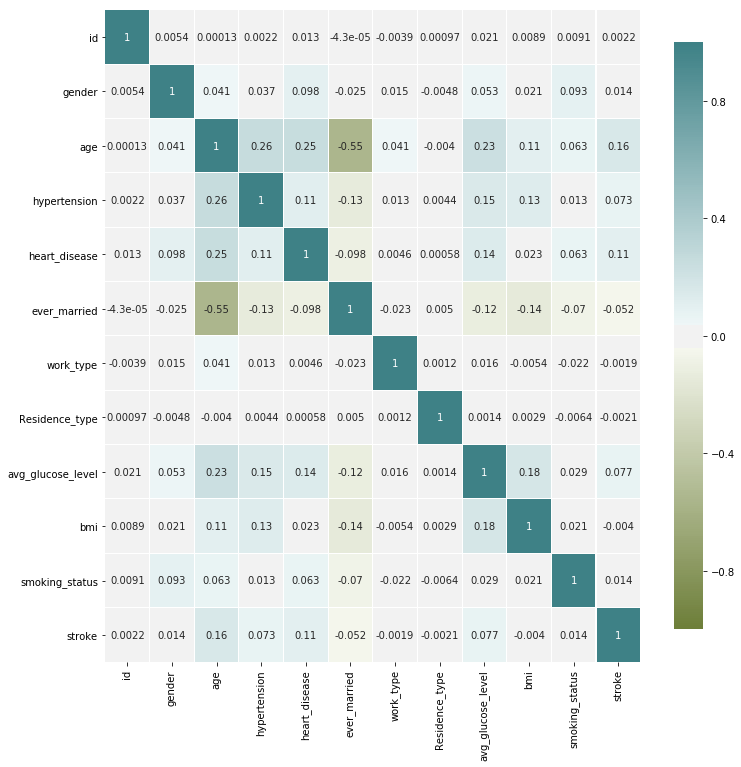

In [21]:
def corrmap(df):
    fig , ax = plt.subplots(figsize =(12, 12))
    fig = sbn.heatmap(df.corr(), cmap = sbn.diverging_palette(100, 200, as_cmap = True), cbar_kws={'shrink':.9 }, ax=ax,annot=True, linewidths=0.05, vmin=-1.0, vmax=1.0, linecolor='white')

corrmap(temp)

In [22]:
temp = df

The age of the oldest person

In [23]:
temp['age'].max()

82.0

Dividing the age into categories with an interval of 10 years

In [24]:
def ageconv(x):
    if x<=10:
        return 0
    if x<=20:
        return 1
    if x<=30:
        return 2  
    if x<=40:
        return 3
    if x<=50:
        return 4
    if x<=60:
        return 5
    if x<=70:
        return 6
    if x<=80:
        return 7
    if x<=90:
        return 8
    
temp['agecat'] = df['age'].apply(lambda x: ageconv(x))

In [25]:
temp['agecat'].value_counts()

5    6691
4    6441
3    5521
6    5229
2    5221
0    4598
1    4417
7    4393
8     889
Name: agecat, dtype: int64

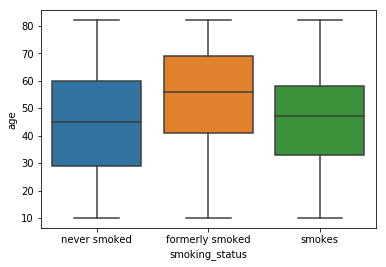

In [26]:
sbn.boxplot(temp['smoking_status'],temp['age'])

Using the boxplot, it can be seen that people less than 20 years old are unlikely to be smokers

The NaN and value counts for ages less than multiple of 10s

In [27]:
for x in range(10,100,10):
    print("Age less than",x)
    temp = df[df['age']<x]
    print("NaN values:",temp['smoking_status'].isnull().sum(axis=0))
    print(temp['smoking_status'].value_counts(),"\n")

Age less than 10
NaN values: 4285
Series([], Name: smoking_status, dtype: int64) 

Age less than 20
NaN values: 6444
never smoked       1621
formerly smoked     269
smokes              177
Name: smoking_status, dtype: int64 

Age less than 30
NaN values: 7529
never smoked       4017
smokes             1247
formerly smoked     918
Name: smoking_status, dtype: int64 

Age less than 40
NaN values: 8668
never smoked       6441
smokes             2366
formerly smoked    1708
Name: smoking_status, dtype: int64 

Age less than 50
NaN values: 9894
never smoked       9156
smokes             3702
formerly smoked    2752
Name: smoking_status, dtype: int64 

Age less than 60
NaN values: 11153
never smoked       11857
smokes              5057
formerly smoked     4206
Name: smoking_status, dtype: int64 

Age less than 70
NaN values: 12158
never smoked       13865
smokes              5936
formerly smoked     5713
Name: smoking_status, dtype: int64 

Age less than 80
NaN values: 13002
never smoked    

From the boxplot, all the people less than 20 years old whose smoking_status is NaN, can be filled as 'never smoked'

In [28]:
def fillsmoking(x):
    if pd.isnull(x['smoking_status']):
        if x['age']<20:
            x['smoking_status'] = "never smoked"
    return x

df = df.apply(lambda x : fillsmoking(x),axis=1)
df.head()    

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,agecat
0,30669,1,3.0,0,0,1,2,1,95.12,18.0,never smoked,0,0
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,never smoked,0,5
2,16523,0,8.0,0,0,1,0,0,110.89,17.6,never smoked,0,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,formerly smoked,0,6
4,46136,1,14.0,0,0,1,4,1,161.28,19.1,never smoked,0,1


In [29]:
df['smoking_status'] = df['smoking_status'].fillna('unknown')
df['smoking_status'].value_counts()

never smoked       22497
formerly smoked     7493
unknown             6848
smokes              6562
Name: smoking_status, dtype: int64

In [30]:
df['smoking_status'] = df['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'unknown': 3} ).astype(int)

Unknown can be dropped later on if found to be of low importance

In [31]:
df['smoking_status'].value_counts()

0    22497
1     7493
3     6848
2     6562
Name: smoking_status, dtype: int64

In [32]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,agecat
0,30669,1,3.0,0,0,1,2,1,95.12,18.0,0,0,0
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,0,0,5
2,16523,0,8.0,0,0,1,0,0,110.89,17.6,0,0,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,1,0,6
4,46136,1,14.0,0,0,1,4,1,161.28,19.1,0,0,1


In [33]:
print("Unique ID's : ", len(df['id'].unique()))

Unique ID's :  43400


Since, 'id' is unique for everyone, it won't be useful in classification and can be dropped

In [34]:
df.drop('id',axis=1,inplace=True)

In [35]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,agecat
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000,43400.000000
mean,0.408894,42.217894,0.093571,0.047512,0.356267,0.832558,0.498710,104.482750,28.605038,0.948410,0.018041,3.683825
std,0.492151,22.519649,0.291235,0.212733,0.478901,1.106406,0.500004,43.111751,7.770020,1.139334,0.133103,2.234833
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,10.100000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.540000,23.200000,0.000000,0.000000,2.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.580000,27.700000,0.000000,0.000000,4.000000
75%,1.000000,60.000000,0.000000,0.000000,1.000000,2.000000,1.000000,112.070000,32.900000,2.000000,0.000000,5.000000
max,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,291.050000,97.600000,3.000000,1.000000,8.000000


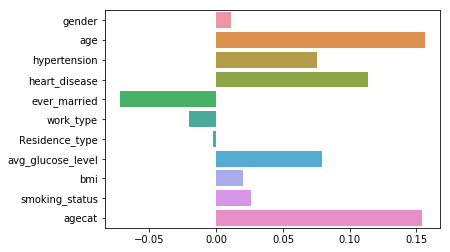

In [36]:
x = df.columns
x = x.drop('stroke')
arr = []
for c in x:
    arr.append(df['stroke'].corr(df[c]))
    
sbn.barplot(arr,x)

In [37]:
print(pd.crosstab(df['smoking_status'],df['stroke']))

stroke              0    1
smoking_status            
0               22211  286
1                7272  221
2                6429  133
3                6705  143


In [38]:
print(len(df[df['stroke']==1])/df.shape[0])

0.01804147465437788


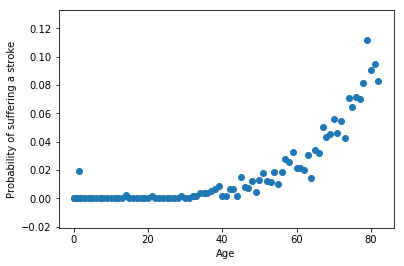

In [39]:
temp = df.pivot_table(index=df['age'],values='stroke',aggfunc=('mean','count'))
plt.scatter(temp.index,temp['mean'])
plt.xlabel("Age")
plt.ylabel("Probability of suffering a stroke")
plt.show()

The probability of suffering a stroke increases with age

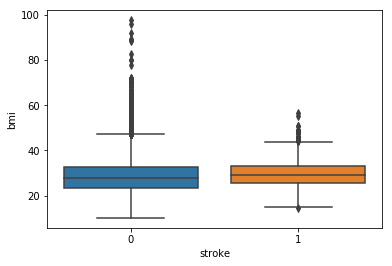

In [40]:
sbn.boxplot(df['stroke'],df['bmi'])

The probability of suffering a stroke increases with BMI (Body Mass Index)

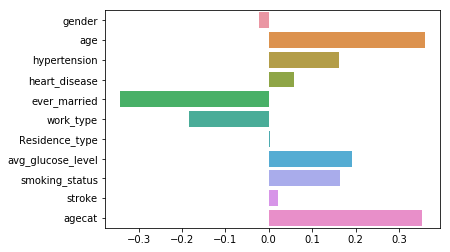

In [41]:
z = df.columns
z = z.drop('bmi')
arr = []
for c in z:
    arr.append(df['bmi'].corr(df[c]))
sbn.barplot(arr,z)

This barplot shows the correlation of BMI with other parameters

In [42]:
print("Median: ",df['bmi'].median())
print("Mean: ",df['bmi'].mean())

Median:  27.7
Mean:  28.605038390004545


In [43]:
df['bmi'].fillna(27.7,inplace=True)

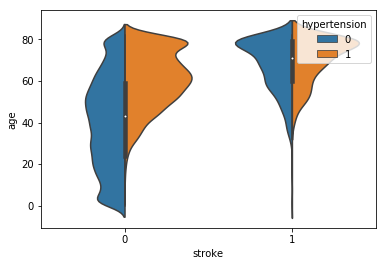

In [44]:
sbn.violinplot(df['stroke'],df['age'],hue=df['hypertension'],split=True)

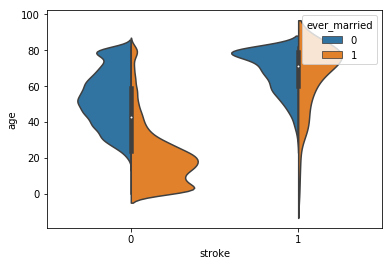

In [45]:
sbn.violinplot(df['stroke'],df['age'],hue=df['ever_married'],split=True)

In [46]:
temp = df
x = temp.columns
x = x.drop('stroke')

### Synthetic Minority Oversampling is done to increase the number of minority class data rows by adding artificial samples

In [47]:
sm = SMOTE(random_state=12, ratio = 0.6)
x_train_res, y_train_res = sm.fit_sample(temp[x], temp['stroke'])
temp = x_train_res
#temp.head()
result = pd.DataFrame(columns=x,data=temp)
result['stroke']=y_train_res
result.shape

/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(68187, 12)

In [48]:
len(result[result['stroke']==1])/result.shape[0]

0.3749981668059894

The minority class is present in 37.4% of all data rows now

In [49]:
# Resampling

result = result.sample(frac=1).reset_index(drop=True)

In [50]:
result.to_csv('/Users/yadushyadav/Downloads/SMOTEdataset.csv',index=False)

In [51]:
df = pd.read_csv('/Users/yadushyadav/Downloads/SMOTEdataset.csv')

In [52]:
reserved_df = df

Saved the dataframe in reserved_df incase of any changes 

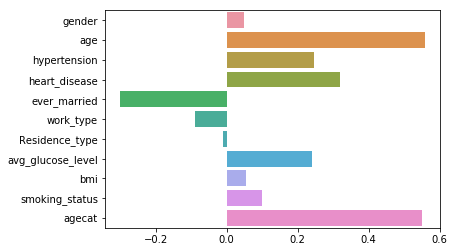

In [53]:
# Correlation between 'stroke' and the other parameters

df = result
x = df.columns
x = x.drop('stroke')
arr = []
for c in x:
    arr.append(df['stroke'].corr(df[c]))
sbn.barplot(arr,x)

In [54]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,agecat,stroke
0,0.552685,56.210741,0.447315,0.000000,0.0,0.552685,0.000000,75.00257,35.147315,0.552685,5.000000,1
1,1.000000,80.000000,1.000000,1.000000,0.0,0.000000,1.000000,102.51000,25.300000,0.000000,7.000000,0
2,1.000000,74.000000,0.000000,0.000000,0.0,0.000000,0.000000,69.02000,28.000000,0.000000,7.000000,0
3,1.000000,58.000000,0.000000,0.000000,0.0,0.000000,1.000000,75.20000,26.700000,0.000000,5.000000,0
4,0.000000,79.351130,0.000000,0.824435,0.0,0.824435,0.175565,187.82965,25.933574,0.000000,7.175565,1


In [55]:
cols = df.columns
cols = cols.drop('stroke')
x = df[cols]
y = df['stroke']

In [56]:
kf = KFold(n_splits=5)

In [57]:
# KFold cross validation to optimize the parameters
# Stratified KFold cross validation can also be used

r = []

for train_index, test_index in kf.split(df):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    model = RandomForestClassifier()
    model.fit(xtrain,ytrain)
    pred = model.predict(xtest)
    r.append(f1_score(pred,ytest))

c=0   
for i in ytest:
    if i==1:
        c+=1
        
print(c/len(ytest))
print(np.mean(r))

0.37500916623890884
0.9827482616002248


In [58]:
cols = cols.drop('agecat')

In [59]:
xtrain,xtest,ytrain,ytest = train_test_split(df[cols],df['stroke'],test_size=0.2,random_state=0)

In [60]:
d = []
f = []
r = []
p = []
n = []
t = []

In [61]:
time1 = datetime.now()

model = LogisticRegression()
model.fit(xtrain,ytrain)
pred1 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred1,ytest))
f.append(f1_score(pred1,ytest))
p.append(precision_score(pred1,ytest))
r.append(recall_score(pred1,ytest))

n.append('LogisticRegression')

print(time2-time1)

0:00:00.276099


In [62]:
time1 = datetime.now()

model = SGDClassifier()
model.fit(xtrain,ytrain)
pred2 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred2,ytest))
f.append(f1_score(pred2,ytest))
p.append(precision_score(pred2,ytest))
r.append(recall_score(pred2,ytest))

n.append('SGDClassifier')

print(time2-time1)

0:00:00.050080


/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [63]:
time1 = datetime.now()

model = RandomForestClassifier(min_samples_leaf = 1, n_estimators = 400)
model.fit(xtrain,ytrain)
pred3 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred3,ytest))
f.append(f1_score(pred3,ytest))
p.append(precision_score(pred3,ytest))
r.append(recall_score(pred3,ytest))

n.append('RandomForestClassifier')

print(time2-time1)

0:00:21.808457


In [64]:
#time1 = datetime.now()
#model = GaussianProcessClassifier()
#model.fit(xtrain,ytrain)
#pred5 = model.predict(xtest)
#time2 = datetime.now()
#t.append(time2-time1)
#d.append(roc_auc_score(pred5,ytest))
#n.append('GaussianProcessClassifier')
#print(time2-time1)

In [65]:
time1 = datetime.now()

model = DecisionTreeClassifier()
model.fit(xtrain,ytrain)
pred6 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred6,ytest))
f.append(f1_score(pred6,ytest))
p.append(precision_score(pred6,ytest))
r.append(recall_score(pred6,ytest))

n.append('DecisionTreeClassifier')

print(time2-time1)

0:00:00.192664


In [66]:
time1 = datetime.now()

model = AdaBoostClassifier()
model.fit(xtrain,ytrain)
pred7 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

f.append(f1_score(pred7,ytest))
p.append(precision_score(pred7,ytest))
r.append(recall_score(pred7,ytest))
d.append(roc_auc_score(pred7,ytest))

n.append('AdaBoostClassifier')

print(time2-time1)

0:00:01.741179


In [67]:
time1 = datetime.now()

model = GaussianNB()
model.fit(xtrain,ytrain)
pred8 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

f.append(f1_score(pred8,ytest))
p.append(precision_score(pred8,ytest))
r.append(recall_score(pred8,ytest))
d.append(roc_auc_score(pred8,ytest))

n.append('GaussianN')

print(time2-time1)

0:00:00.026971


In [68]:
time1 = datetime.now()

model = QuadraticDiscriminantAnalysis()
model.fit(xtrain,ytrain)
pred9 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred9,ytest))
f.append(f1_score(pred9,ytest))
p.append(precision_score(pred9,ytest))
r.append(recall_score(pred9,ytest))

n.append('QuadraticDiscriminantAnalysis')

print(time2-time1)

0:00:00.040369


In [69]:
time1 = datetime.now()

model = MLPClassifier()
model.fit(xtrain,ytrain)
pred10 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred10,ytest))
f.append(f1_score(pred10,ytest))
p.append(precision_score(pred10,ytest))
r.append(recall_score(pred10,ytest))

n.append('MLPClassifier')

print(time2-time1)

0:00:13.352489


In [70]:
time1 = datetime.now()

model = KNeighborsClassifier()
model.fit(xtrain,ytrain)
pred11 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred11,ytest))
f.append(f1_score(pred11,ytest))
p.append(precision_score(pred11,ytest))
r.append(recall_score(pred11,ytest))

n.append('KNeighborsClassifier')

print(time2-time1)

0:00:00.280577


In [71]:
time1 = datetime.now()

model = GradientBoostingClassifier()
model.fit(xtrain,ytrain)
pred12 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred12,ytest))
f.append(f1_score(pred12,ytest))
p.append(precision_score(pred12,ytest))
r.append(recall_score(pred12,ytest))

n.append('GradientBoostingClassifier')

print(time2-time1)

0:00:03.890293


In [72]:
time1 = datetime.now()

model = ExtraTreesClassifier()
model.fit(xtrain,ytrain)
pred13 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred13,ytest))
f.append(f1_score(pred13,ytest))
p.append(precision_score(pred13,ytest))
r.append(recall_score(pred13,ytest))

n.append('ExtraTreesClassifier')

print(time2-time1)

0:00:00.326096


In [73]:
time1 = datetime.now()

model = BaggingClassifier(n_estimators = 500, max_samples = 0.5, max_features = 0.5)
model.fit(xtrain,ytrain)
pred15 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred15,ytest))
f.append(f1_score(pred15,ytest))
p.append(precision_score(pred15,ytest))
r.append(recall_score(pred15,ytest))

n.append('BaggingClassifier')

print(time2-time1)

0:00:20.084427


In [74]:
time1 = datetime.now()

model = xgb.XGBClassifier()
model.fit(xtrain,ytrain)
pred16 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred16,ytest))
f.append(f1_score(pred16,ytest))
p.append(precision_score(pred16,ytest))
r.append(recall_score(pred16,ytest))

n.append('XGBClassifier')

print(time2-time1)

0:00:03.255619


/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [75]:
time1 = datetime.now()

model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1)
model.fit(xtrain,ytrain)
pred17 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred17,ytest))
f.append(f1_score(pred17,ytest))
p.append(precision_score(pred17,ytest))
r.append(recall_score(pred17,ytest))

n.append('CatBoostClassifier')

print(time2-time1)

0:	learn: 0.5738694	total: 89ms	remaining: 1m 28s
1:	learn: 0.4652878	total: 125ms	remaining: 1m 2s
2:	learn: 0.3880493	total: 159ms	remaining: 52.7s
3:	learn: 0.3375072	total: 193ms	remaining: 48.1s
4:	learn: 0.2923049	total: 229ms	remaining: 45.6s
5:	learn: 0.2635813	total: 265ms	remaining: 43.9s
6:	learn: 0.2281542	total: 302ms	remaining: 42.9s
7:	learn: 0.2111531	total: 332ms	remaining: 41.2s
8:	learn: 0.1903390	total: 367ms	remaining: 40.4s
9:	learn: 0.1736683	total: 401ms	remaining: 39.7s
10:	learn: 0.1588258	total: 432ms	remaining: 38.8s
11:	learn: 0.1455894	total: 465ms	remaining: 38.3s
12:	learn: 0.1392998	total: 499ms	remaining: 37.9s
13:	learn: 0.1303672	total: 538ms	remaining: 37.9s
14:	learn: 0.1226343	total: 571ms	remaining: 37.5s
15:	learn: 0.1171690	total: 598ms	remaining: 36.8s
16:	learn: 0.1114174	total: 632ms	remaining: 36.6s
17:	learn: 0.1060647	total: 663ms	remaining: 36.2s
18:	learn: 0.1018006	total: 698ms	remaining: 36.1s
19:	learn: 0.0991415	total: 733ms	remaini

161:	learn: 0.0546382	total: 3.67s	remaining: 19s
162:	learn: 0.0544781	total: 3.7s	remaining: 19s
163:	learn: 0.0544326	total: 3.74s	remaining: 19.1s
164:	learn: 0.0542889	total: 3.77s	remaining: 19.1s
165:	learn: 0.0541650	total: 3.8s	remaining: 19.1s
166:	learn: 0.0541171	total: 3.84s	remaining: 19.1s
167:	learn: 0.0539686	total: 3.88s	remaining: 19.2s
168:	learn: 0.0538857	total: 3.91s	remaining: 19.2s
169:	learn: 0.0537830	total: 3.94s	remaining: 19.3s
170:	learn: 0.0536571	total: 3.98s	remaining: 19.3s
171:	learn: 0.0536145	total: 4.01s	remaining: 19.3s
172:	learn: 0.0535622	total: 4.04s	remaining: 19.3s
173:	learn: 0.0535079	total: 4.08s	remaining: 19.4s
174:	learn: 0.0534665	total: 4.12s	remaining: 19.4s
175:	learn: 0.0533919	total: 4.15s	remaining: 19.4s
176:	learn: 0.0533349	total: 4.19s	remaining: 19.5s
177:	learn: 0.0532952	total: 4.22s	remaining: 19.5s
178:	learn: 0.0531712	total: 4.26s	remaining: 19.5s
179:	learn: 0.0531016	total: 4.3s	remaining: 19.6s
180:	learn: 0.05299

326:	learn: 0.0439587	total: 6.84s	remaining: 14.1s
327:	learn: 0.0439076	total: 6.86s	remaining: 14.1s
328:	learn: 0.0438529	total: 6.88s	remaining: 14s
329:	learn: 0.0438203	total: 6.89s	remaining: 14s
330:	learn: 0.0437513	total: 6.9s	remaining: 13.9s
331:	learn: 0.0435923	total: 6.92s	remaining: 13.9s
332:	learn: 0.0435366	total: 6.93s	remaining: 13.9s
333:	learn: 0.0435117	total: 6.94s	remaining: 13.8s
334:	learn: 0.0434839	total: 6.96s	remaining: 13.8s
335:	learn: 0.0434356	total: 6.97s	remaining: 13.8s
336:	learn: 0.0434004	total: 6.99s	remaining: 13.7s
337:	learn: 0.0433427	total: 7s	remaining: 13.7s
338:	learn: 0.0433060	total: 7.01s	remaining: 13.7s
339:	learn: 0.0432691	total: 7.03s	remaining: 13.6s
340:	learn: 0.0432472	total: 7.04s	remaining: 13.6s
341:	learn: 0.0432116	total: 7.06s	remaining: 13.6s
342:	learn: 0.0431752	total: 7.08s	remaining: 13.6s
343:	learn: 0.0431549	total: 7.09s	remaining: 13.5s
344:	learn: 0.0431143	total: 7.1s	remaining: 13.5s
345:	learn: 0.0430563

491:	learn: 0.0373271	total: 9.14s	remaining: 9.44s
492:	learn: 0.0372999	total: 9.16s	remaining: 9.42s
493:	learn: 0.0372723	total: 9.18s	remaining: 9.4s
494:	learn: 0.0372560	total: 9.19s	remaining: 9.37s
495:	learn: 0.0372344	total: 9.2s	remaining: 9.35s
496:	learn: 0.0372005	total: 9.21s	remaining: 9.33s
497:	learn: 0.0371755	total: 9.23s	remaining: 9.3s
498:	learn: 0.0371543	total: 9.24s	remaining: 9.28s
499:	learn: 0.0371178	total: 9.26s	remaining: 9.26s
500:	learn: 0.0370827	total: 9.27s	remaining: 9.23s
501:	learn: 0.0370512	total: 9.28s	remaining: 9.21s
502:	learn: 0.0370029	total: 9.29s	remaining: 9.18s
503:	learn: 0.0369611	total: 9.31s	remaining: 9.16s
504:	learn: 0.0369134	total: 9.32s	remaining: 9.14s
505:	learn: 0.0368764	total: 9.33s	remaining: 9.11s
506:	learn: 0.0368100	total: 9.35s	remaining: 9.09s
507:	learn: 0.0367712	total: 9.37s	remaining: 9.07s
508:	learn: 0.0367498	total: 9.38s	remaining: 9.05s
509:	learn: 0.0367337	total: 9.4s	remaining: 9.03s
510:	learn: 0.03

654:	learn: 0.0324466	total: 11.4s	remaining: 6.02s
655:	learn: 0.0324187	total: 11.4s	remaining: 6s
656:	learn: 0.0324017	total: 11.5s	remaining: 5.99s
657:	learn: 0.0323750	total: 11.5s	remaining: 5.96s
658:	learn: 0.0323595	total: 11.5s	remaining: 5.95s
659:	learn: 0.0323282	total: 11.5s	remaining: 5.93s
660:	learn: 0.0323003	total: 11.5s	remaining: 5.91s
661:	learn: 0.0322701	total: 11.5s	remaining: 5.89s
662:	learn: 0.0322563	total: 11.5s	remaining: 5.87s
663:	learn: 0.0322384	total: 11.6s	remaining: 5.85s
664:	learn: 0.0322106	total: 11.6s	remaining: 5.83s
665:	learn: 0.0321842	total: 11.6s	remaining: 5.81s
666:	learn: 0.0321434	total: 11.6s	remaining: 5.79s
667:	learn: 0.0321369	total: 11.6s	remaining: 5.77s
668:	learn: 0.0321133	total: 11.6s	remaining: 5.75s
669:	learn: 0.0320929	total: 11.6s	remaining: 5.74s
670:	learn: 0.0320660	total: 11.7s	remaining: 5.72s
671:	learn: 0.0320481	total: 11.7s	remaining: 5.7s
672:	learn: 0.0320074	total: 11.7s	remaining: 5.68s
673:	learn: 0.03

827:	learn: 0.0284859	total: 14.1s	remaining: 2.93s
828:	learn: 0.0284769	total: 14.1s	remaining: 2.92s
829:	learn: 0.0284601	total: 14.2s	remaining: 2.9s
830:	learn: 0.0284495	total: 14.2s	remaining: 2.88s
831:	learn: 0.0284288	total: 14.2s	remaining: 2.86s
832:	learn: 0.0284088	total: 14.2s	remaining: 2.85s
833:	learn: 0.0283852	total: 14.2s	remaining: 2.83s
834:	learn: 0.0283648	total: 14.2s	remaining: 2.81s
835:	learn: 0.0283416	total: 14.2s	remaining: 2.79s
836:	learn: 0.0283208	total: 14.2s	remaining: 2.77s
837:	learn: 0.0282882	total: 14.3s	remaining: 2.76s
838:	learn: 0.0282762	total: 14.3s	remaining: 2.74s
839:	learn: 0.0282641	total: 14.3s	remaining: 2.72s
840:	learn: 0.0282468	total: 14.3s	remaining: 2.7s
841:	learn: 0.0282332	total: 14.3s	remaining: 2.69s
842:	learn: 0.0282183	total: 14.3s	remaining: 2.67s
843:	learn: 0.0281920	total: 14.4s	remaining: 2.65s
844:	learn: 0.0281739	total: 14.4s	remaining: 2.64s
845:	learn: 0.0281636	total: 14.4s	remaining: 2.63s
846:	learn: 0.

999:	learn: 0.0253017	total: 17.5s	remaining: 0us
0:00:18.102124


In [76]:
# Feature Importance

#feature_importances = model.get_feature_importance()
#feature_names = xtrain.columns
#sbn.barplot(feature_importances,feature_names)

In [77]:
print(roc_auc_score(pred17,ytest))
print(roc_auc_score(pred15,ytest))
print(roc_auc_score(pred13,ytest))
print(roc_auc_score(pred3,ytest))

0.990437301508237
0.9898773715872282
0.9898854038499001
0.990523798351321


In [78]:
print(f1_score(pred17,ytest))
print(f1_score(pred15,ytest))
print(f1_score(pred13,ytest))
print(f1_score(pred3,ytest))

0.9844041196665032
0.9827806749975401
0.9849609375
0.9843979982337356


Text(0.5,1,'ROC AUC Score')

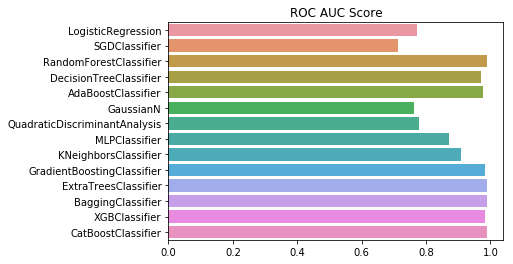

In [79]:
# roc_auc_score
sbn.barplot(d,n).set_title("ROC AUC Score")

Text(0.5,1,'F-1 Score')

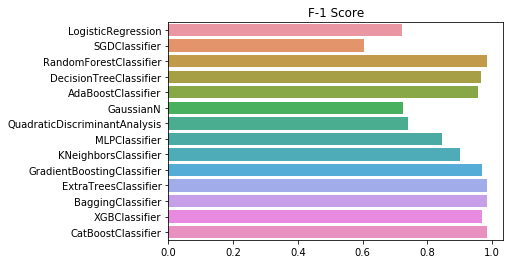

In [80]:
# f-1 score
sbn.barplot(f,n).set_title("F-1 Score")

Text(0.5,1,'Precision')

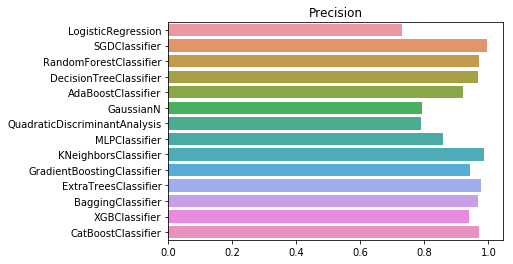

In [81]:
# precision
sbn.barplot(p,n).set_title("Precision")

Text(0.5,1,'Recall')

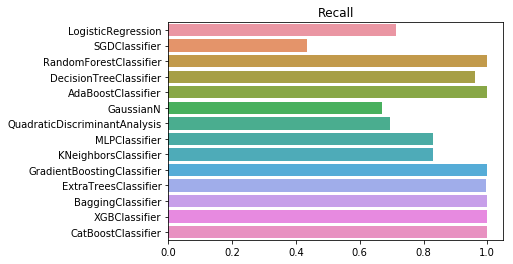

In [82]:
# recall
sbn.barplot(r,n).set_title("Recall")

Text(0.5,1,'Time Taken')

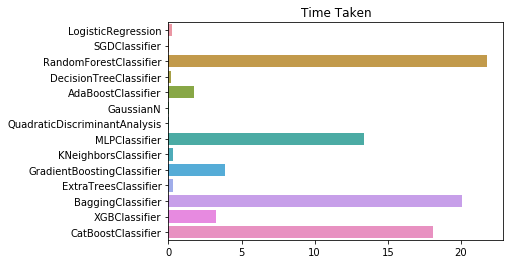

In [83]:
sbn.barplot(t,n).set_title("Time Taken")